In [1]:
import gc, glob, os
from concurrent.futures import ProcessPoolExecutor

import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import norm
from timm import create_model
from tqdm import tqdm
from pathlib import Path


def normalize(X):
    X = (X[..., None].view(X.real.dtype) ** 2).sum(-1)
    POS = int(X.size * 0.99903)
    EXP = norm.ppf((POS + 0.4) / (X.size + 0.215))
    scale = np.partition(X.flatten(), POS, -1)[POS]
    X /= scale / EXP.astype(scale.dtype) ** 2
    return X


def dataload(filepath):
    astime = np.full([2, 360, 5760], np.nan, dtype=np.float32)
    with h5py.File(filepath, "r") as f:
        fid, _ = os.path.splitext(os.path.split(filepath)[1])
        HT = (
            (np.asarray(f[fid]["H1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        LT = (
            (np.asarray(f[fid]["L1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        MIN = min(HT.min(), LT.min())
        HT -= MIN
        LT -= MIN
        H1 = normalize(np.asarray(f[fid]["H1"]["SFTs"], np.complex128))
        valid = HT < 5760
        astime[0][:, HT[valid]] = H1[:, valid]
        L1 = normalize(np.asarray(f[fid]["L1"]["SFTs"], np.complex128))
        valid = LT < 5760
        astime[1][:, LT[valid]] = L1[:, valid]
    gc.collect()
    return fid, astime, H1.mean(), L1.mean()




def preprocess(num, input, H1, L1):
    input = torch.from_numpy(input).to("cuda", non_blocking=True)
    rescale = torch.tensor([[H1, L1]]).to("cuda", non_blocking=True)
    tta = (
        torch.randn([num, *input.shape, 2], device=input.device, dtype=torch.float32)
        .square_()
        .sum(-1)
    )
    tta *= rescale[..., None, None] / 2
    valid = ~torch.isnan(input)
    tta[:, valid] = input[valid].float()
    return tta


class LargeKernel_debias(nn.Conv2d):
    def forward(self, input: torch.Tensor):
        finput = input.flatten(0, 1)[:, None]
        target = abs(self.weight)
        target = target / target.sum((-1, -2), True)
        joined_kernel = torch.cat([self.weight, target], 0)
        reals = target.new_zeros(
            [1, 1] + [s + p * 2 for p, s in zip(self.padding, input.shape[-2:])]
        )
        reals[
            [slice(None)] * 2
            + [slice(p, -p) if p != 0 else slice(None) for p in self.padding]
        ].fill_(1)
        output, power = torch.nn.functional.conv2d(
            finput, joined_kernel, padding=self.padding
        ).chunk(2, 1)
        ratio = torch.div(*torch.nn.functional.conv2d(reals, joined_kernel).chunk(2, 1))
        output = output.sub(power.mul(ratio))
        return output.unflatten(0, input.shape[:2]).flatten(1, 2)
    

def get_model(path):
    model = create_model(
        "tf_efficientnetv2_b0",
        in_chans=32,
        num_classes=2,
    )
    state_dict = torch.load(path)
    C, _, H, W = state_dict["conv_stem.2.weight"].shape
    print(C, _, H, W)
    model.conv_stem = nn.Sequential(
        nn.Identity(),
        nn.AvgPool2d((1, 9), (1, 8), (0, 4), count_include_pad=False),
        LargeKernel_debias(1, C, [H, W], 1, [H // 2, W // 2], 1, 1, False),
        model.conv_stem,
    )
    model.load_state_dict(state_dict)
    return model.conv_stem[:3]

class LargeKernelModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.head = get_model('model_best.pth')
        self.enc = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=CFG.num_classes,
                    in_chans=32,
                )
        
    def forward(self, x):
        x = self.head(x)
        return self.enc(x)


@torch.no_grad()
def inference(model, path):
    file_path = glob.glob(os.path.join(path, "*.hdf5"))
    FID, RES = [], []
    with ProcessPoolExecutor(2) as pool:
        for fid, input, H1, L1 in tqdm(pool.map(dataload, sorted(file_path))):
            tta = preprocess(64, input, H1, L1)
            FID += [fid]
            RES += [model(tta).sigmoid().mean(0)]
    return FID, torch.stack(RES, 0).cpu().float().numpy()

In [2]:
class CFG:
    bs = 32
    nw = 8
    model_name = "convnext_large_in22k"
    lr = 1e-4
    wd = 1e-4
    epoch = 10
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_50_00_PSD"
    mixup=False
    split_voldf = Path("../data/SPLITS/V_20")
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}_{mixup}_POS"

In [3]:
model =  LargeKernelModel(CFG)
model.load_state_dict(torch.load('../EXP_50/EXP_50_00/EXP_50_00_convnext_large_in22k_V_20_False_FT_PSD_DATA_33_0_4.pth'))
model.eval();
model.cuda();

fid, infer = inference(model, "../data/test")
result = pd.DataFrame.from_dict({"id": fid, "target": infer.reshape(-1)})

16 1 31 255


7975it [5:52:52,  2.65s/it]


In [4]:
result.to_csv('EXP_50_64_CONVNEXT_large_psd.csv', index=False)

<AxesSubplot:ylabel='Frequency'>

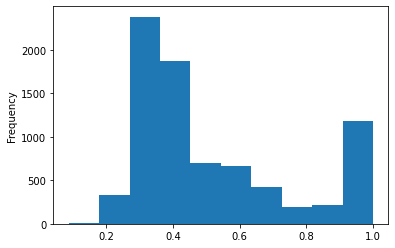

In [5]:
result['target'].plot.hist()

In [6]:
k

NameError: name 'k' is not defined